## In this notebook, a model is trained using a csv file that contains user marked spam and ham messages. Then it will take a custom user message to evaluate whether it is spam or ham.

### Importing libraries: Step 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

In [2]:
sms = pd.read_csv('spam.csv',encoding='ISO-8859-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


### Data cleaning: remove unnecessary columns

In [4]:
sms.drop(labels= ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
sms.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Rename the columns and describe the dataframe

In [5]:
sms.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


### Make Word clouds of ham and spam messages by firstly creating a string of ham and spam respectively and then using WordCloud library.

In [7]:
ham_msg_text = ' '.join(sms[sms['label'] == 'ham']['message'])
spam_msg_text = ' '.join(sms[sms['label'] == 'spam']['message'])

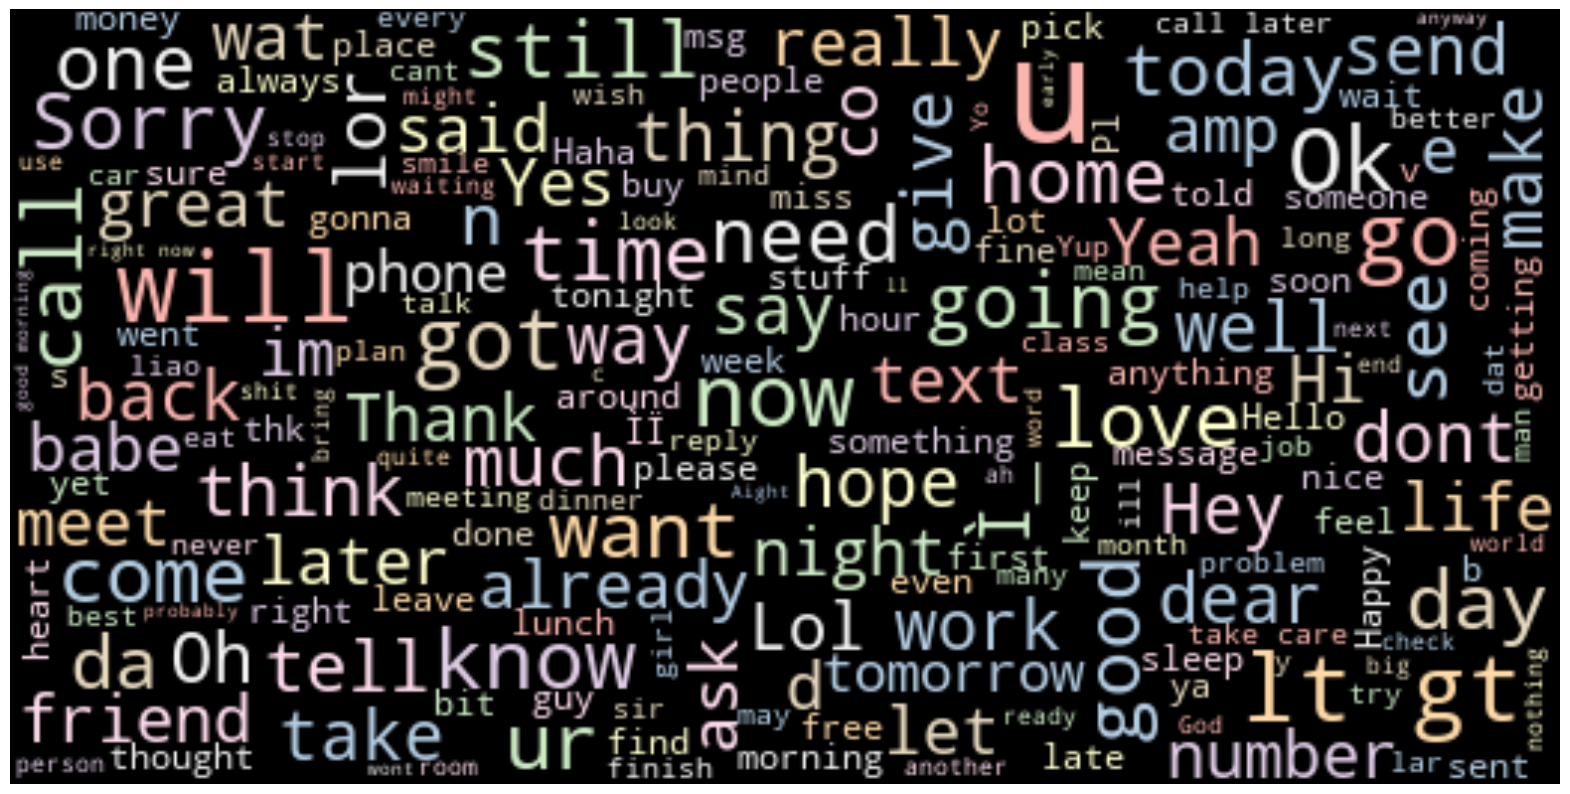

In [8]:
ham_msg_cloud = WordCloud(width =520,
                          height =260,
                          stopwords = STOPWORDS,
                          max_font_size = 50,
                          background_color = "black",
                          colormap = 'Pastel1').generate(ham_msg_text)
plt.figure(figsize=(20,14))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

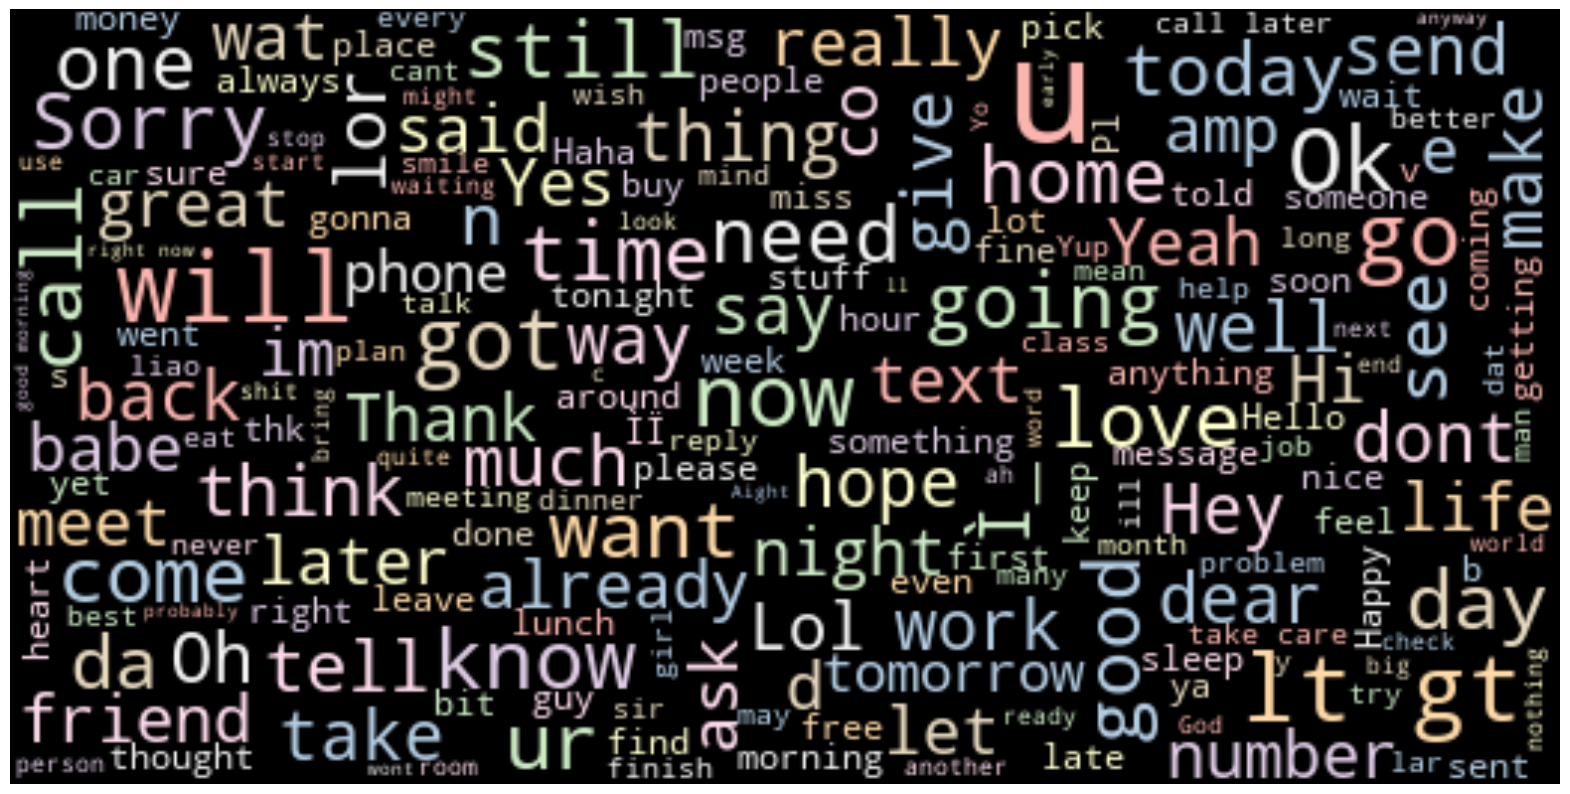

In [9]:
spam_msg_cloud = WordCloud(width =520,
                          height =260,
                          stopwords = STOPWORDS,
                          max_font_size = 50,
                          background_color = "black",
                          colormap = 'Pastel1').generate(spam_msg_text)
plt.figure(figsize=(20,14))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_10772\3830203958.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sms, x='label', palette='pastel', saturation=1)


Text(0.5, 1.0, 'The message count distribution between ham and spam')

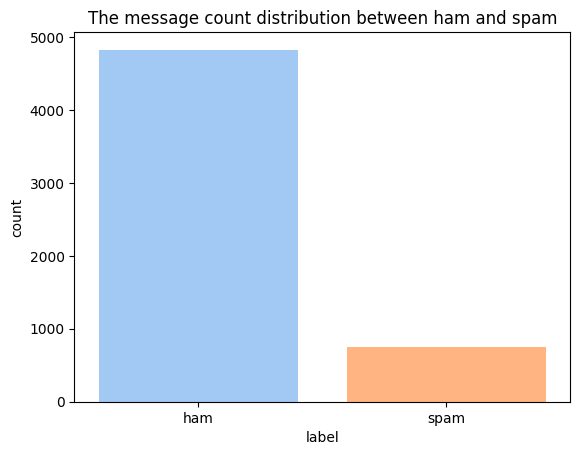

In [10]:
sns.countplot(data=sms, x='label', palette='pastel', saturation=1)
plt.title("The message count distribution between ham and spam")

In [11]:
print(f"Total number of ham enteries: {len(sms[sms['label'] == 'ham'])}")
print(f"Total number of spam enteries: {len(sms[sms['label'] == 'spam'])}")

Total number of ham enteries: 4825
Total number of spam enteries: 747


In [12]:
sms_ham = sms[sms['label'] == 'ham']
sms_spam = sms[sms['label'] == 'spam']
sms_ham_downsampled = sms_ham.sample(n = len(sms_spam), random_state = 44)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_10772\976308352.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pd.concat([sms_ham_downsampled, sms_spam]), x='label', palette='pastel', saturation=1)


Text(0.5, 1.0, 'The message count distribution between ham and spam after ham downsampling')

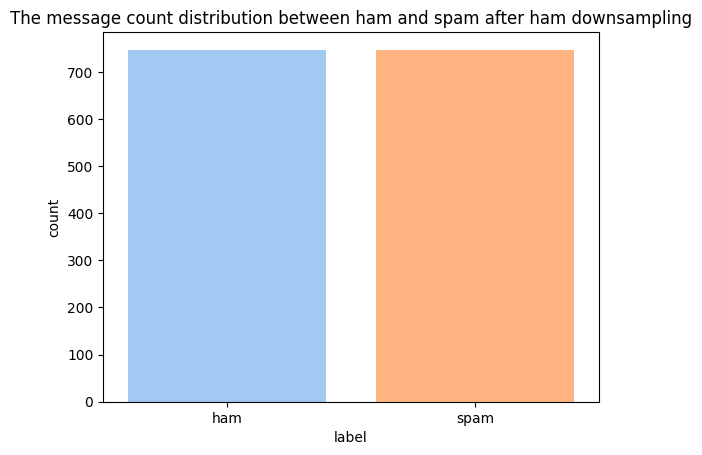

In [13]:
sns.countplot(data=pd.concat([sms_ham_downsampled, sms_spam]), x='label', palette='pastel', saturation=1)
plt.title("The message count distribution between ham and spam after ham downsampling")

In [14]:
# Dataframe for feeding into text preprocessing after downsampling of ham dataset.
sms_downsampled = pd.concat([sms_ham_downsampled, sms_spam])
sms_downsampled.head()

,label,message
3234,ham,"Yes, princess. Toledo."
3804,ham,Dude while were makin those weirdy brownies my...
2701,ham,"Hiya, sorry didn't hav signal. I haven't seen ..."
2822,ham,Then u ask darren go n pick u lor... But i oso...
5161,ham,Lol no. I just need to cash in my nitros. Hurr...
